# Analiza danych #3. Wykorzystanie metod klasyfikacji

### Tematem dzisiejszego posta są algorytmy klasyfikujące. Chciałbym skupić się na dwóch z nich – K Nearest Neighbours (KNN) oraz Support Vector Machines (SVM). Są to jedne z najbardziej znanych metod wykorzystywanych w klasyfikacji, zwłaszcza kiedy klas jest więcej niż dwie i regresja logistyczna nie może zostać wykorzystana. Zamierzam zastosować je do stworzenia modeli, które będą rozpoznawać gatunki irysa na podstawie wymiarów poszczególnych części kwiatu. Odpowiednie dane znajdują się w jednym z klasyków machine learningu czyli Iris Dataset.

Jak zwykle zanim przejdę do tworzenia modelu uczącego zamierzam napisać coś na temat danych – jaka jest ich struktura, co przedstawiają i tak dalej. W tym przypadku mamy do czynienia z raczej niewielką ilością ficzerów (czy też kolumn) datasetu. Są one cztery i dotyczą długości oraz szerokości dwóch różnych części kwiatu – działki kielicha (ang. sepal) oraz płatka (ang. petal). Oprócz tych danych numerycznych każdy okaz jest zlabelowany, podpisany. To znaczy, że dostajemy informację do jakiego gatunku irysa należy kwiat o podanych wymiarach. Jako ciekawostkę a przy okazji uściślenie dodam, że z punktu widzenia klasyfikacji biologicznej irys jest rodzajem i w jego obrębie funkcjonuje kilka gatunków. Tutaj mamy do czynienia z trzema, są nimi: Setosa, Versicolor oraz Virginica. Zadanie jakie jest do wykonania narzuca się samo – należy stworzyć program, który na podstawie samych wymiarów konkretnego okazu zwróci nam informację o tym do jakiego gatunku ten okaz należy.

### Wizualizacja danych wielowymiarowych
   Ilość cech jaką dysponujemy w pracy z Iris Dataset jest zarówno mała jak i duża. Mała – bo nie ma praktycznie żadnego zróżnicowania w interpretacji poszczególnych kolumn. Wszystkie dotyczą wymiaru podanego w centymetrach a to czy mówimy o długości, czy szerokości albo działce kielicha czy płatku nie jest aż tak istotne. Duża – bo liczba wymiarów jest większa niż liczba wymiarów przestrzeni w której żyjemy. Łatwo przedstawić długość i szerokość jakiegoś obiektu na dwuwymiarowym wykresie i wyświetlić go na ekranie monitora. Można nawet dorzucić trzeci wymiar i zwizualizować go korzystając z perspektywy. Ale co zrobić w przypadku kiedy wymiarów jest więcej a w pewnym sensie należą one do tej samej przestrzeni (czego raczej nie powiemy o na przykład danych pogodowych z poprzedniego posta. Z matematyki wiemy, że rozmiary obiektu 2D albo 3D da się przedstawić jako punkt w przestrzeni o odpowiedniej liczbie wymiarów. Łatwo więc intuicyjnie wyczuć, że gdybyśmy tylko mieli ich do dyspozycji więcej moglibyśmy dalej robić to samo. Jak więc dostać się do tych dalszych wymiarów, których nie potrafimy wyrazić w tradycyjny sposób?
   
   Nie chcę zbytnio skupiać się na tym zagadnieniu, ponieważ nie jest ono w tym wpisie motywem przewodnim, ale wspominam o nim, ponieważ Iris Dataset dobrze nadaje się do pokazania jak zmieścić na 2D większą liczbę wymiarów. Temat jest ciekawy, wiąże się również z tak zwaną redukcją wymiarowości (ang. dimensionality reduction). Być może kiedyś powstanie osobny wpis na ten temat. Przedstawiać graficznie “wyższe wymiary” można na różne sposoby. W zależności od tego ile ich jest można korzystać z różnych metod. Tutaj pokażę jeden przykładowy sposób, ale tylko od naszej kreatywności zależy jak podejdziemy do tego problemu.

   Tak więc mamy do wizualizacji cztery cechy, spośród których wszystkie są pewnym wymiarem liniowym. Dobrym sposobem wydaje się pogrupować je “każdy z każdym” i wszystkie w ten sposób uzyskane pary przedstawić na oddzielnym wykresie.

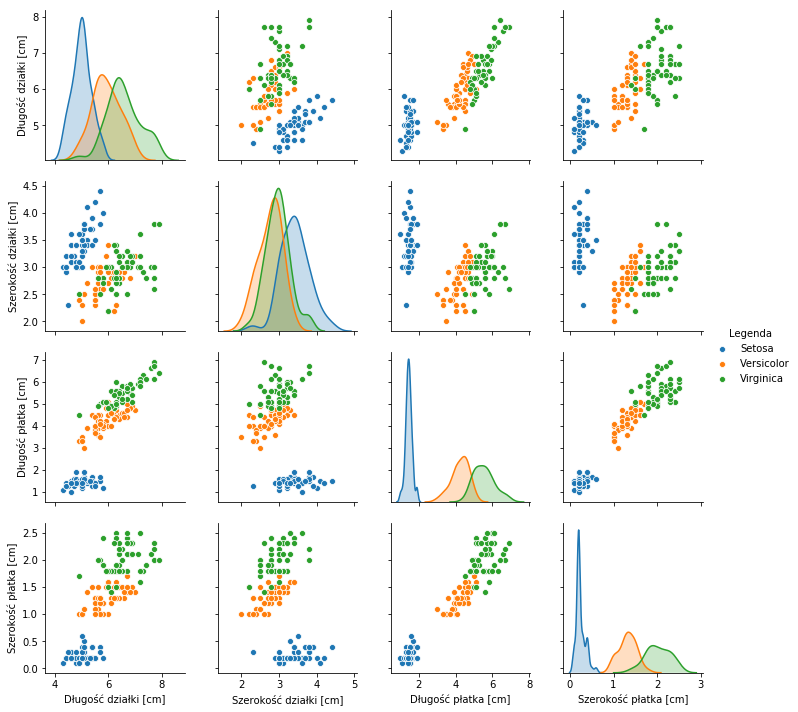

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('dane/iris.csv')
df['Legenda'] = df['variety']
df['variety'].replace( {'Setosa':1, 'Versicolor':2, 'Virginica':3}, inplace = True)

# I. Wizualizacja
fig = plt.figure(figsize = (4,4), facecolor = 'white')

df.rename(columns={'petal.length':'Długość płatka [cm]', 'petal.width':'Szerokość płatka [cm]', \
'sepal.length': 'Długość działki [cm]', 'sepal.width':'Szerokość działki [cm]'}, index = str, inplace = True)
sns.pairplot(df.drop(['variety'], axis = 1), hue = 'Legenda')

Tak więc udało się dość sprytnie zobrazować wszystkie cztery cechy. Trzeba było co prawda stworzyć sześć osobnych wykresów (pozostałe sześć to te same tylko z zamienionymi osiami). Jest to jednak dobry sposób kiedy chcemy zobaczyć jak zależą od siebie wszystkie cechy na zasadzie “każdy z każdym”. Korzystając z wbudowanej do biblioteki seaborn funkcji pairplot() uzyskałem dodatkowo rozkłady wszystkich cech z podziałem na poszczególne gatunki irysa.

## Klasyfikacja
  Na podstawie powyższej wizualizacji można zauważyć, że istnieją pewne prawidłowości w rozmiarach irysów. To sugeruje, że dałoby się dokonać klasyfikacji  nowych, nieopisanych danych za pomocą modelu wcześniej nauczonego danymi treningowymi. Wykorzystam do tego dwie popularne metody które w machine learningu wykorzystuje się do klasyfikacji. Będą to K Nearest Neighbors (KNN) oraz Support Vector Machines (SVM).

### a) KNN
 Tę metodę najłatwiej zobrazować na przykładzie gdzie liczba cech to 2 z uwagi na to, że wystarczy do tego dwuwymiarowy wykres. Oczywiście z punktu widzenia obliczeń liczba wymiarów nie ma większego znaczenia.

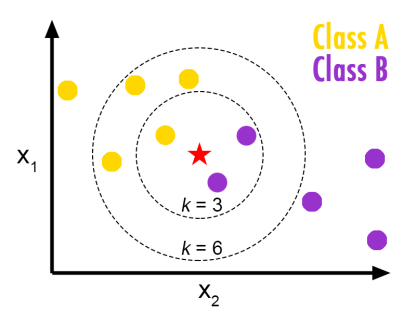

In [8]:
from IPython.display import Image
Image(filename = 'plots/3AD_1.png')

 Na powyższym wykresie mamy przedstawionych kilka obserwacji o dwóch różnych cechach – x1 oraz x2. Każda z tych obserwacji należy w tym przypadku do jednej z dwóch klas (ale może być ich więcej) i jest opisana. Dlatego właśnie KNN należy do nadzorowanych metod uczenia. Następnie wybieramy (arbitralnie) wartość parametru K czyli liczby najbliższych obserwacji w sąsiedztwie tej rozważanej które będziemy brać pod uwagę. Sprawdzamy teraz do której z kategorii należy najwięcej obserwacji wokół naszego punktu i dokonujemy klasyfikacji.

Jest to przedstawienie metody KNN tylko w najbardziej ogólnym zarysie. Omawiając ją dokładniej należałoby wspomnieć chociażby o kwestii standaryzacji danych, metryk i tym podobnych ale nie chciałbym się na tym aż tak skupiać. Bardziej wyczerpujący opis można znaleźć w wielu opracowaniach, które są dostępne w internecie. Polecam na przykład tę pozycję: https://www.ime.unicamp.br/~dias/Intoduction%20to%20Statistical%20Learning.pdf

### b) SVM
  Druga metoda którą pokrótce omówię a następnie wykorzystam do klasyfikacji danych to Support Vector Machines. Działa ona nieco inaczej i ją również najlepiej jest przedstawić na “dwuwymiarowych” danych. Znowu będzie to pokazanie jedynie najprostszego możliwego przypadku, ale nawet w nim jest widoczna idea która stoi za metodą SVM.

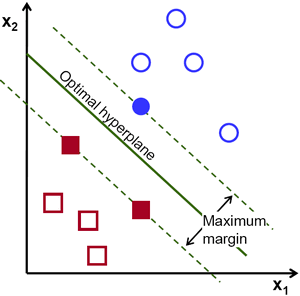

In [9]:
Image(filename = 'plots/3AD_2.png')

Metoda ta polega na wyznaczeniu hiperpłaszczyzny (czyli odpowiednika zwykłej płaszczyzny dla n wymiarów) tak, aby jak najlepiej dzieliła ona dane według klas. Kiedy już uzyskamy taki podział (z wykorzystaniem danych uczących) jesteśmy w stanie określić w którym sektorze przestrzeni znajdują się punkty z danych testowych. Przykład jest widoczny na powyższym rysunku. Tutaj hiperpłaszczyzna jest prostą i została ona poprowadzona w takim miejscu, żeby znaleźć się jak najbardziej pomiędzy obserwacjami z dwóch różnych klas. Po więcej szczegółów znów odsyłam do fachowej literatury.

## Wyniki klasyfikacji…
… wypadają bardzo korzystnie. Obie metody są w stanie sklasyfikować irysy bezbłędnie. W przypadku KNN jednak zanim stworzymy model uczący warto przyłożyć trochę wagi do tego jaką wartość parametru K wybierzemy. Trudno z góry przewiedzieć optymalną wartość tego parametru dlatego można wykonać obliczenia dla pewnego zakresu jego wartości a następnie wybrać najbardziej optymalną. Ja dokładność modelu zdefiniowałem jako stosunek sumy prawidłowych odgadnięć do wszystkich strzałów. W oficjalnej terminologii ten parametr nazywa się accuracy i nie jest on jedynym, z pomocą którego można oceniać poprawność działania modelu, ale wydaje mi się tutaj najbardziej odpowiedni. Jeśli accuracy (dokładność) wynosi 1 oznacza to, że wszystkie obserwacje zostały zaklasyfikowane prawidłowo. Poniższy wykres przedstawia zależność dokładności od 20 różnych K.

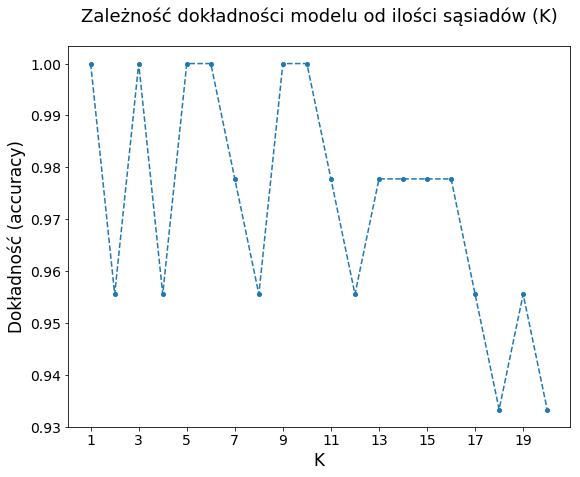

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC


X = df.drop(['variety', 'Legenda'], axis = 1)
y = df['variety']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 101)

accuracyList = []
for k in range(1,21):
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    predictions = knn.predict(X_test)
    accuracyList.append(accuracy_score(y_test, predictions))

fig = plt.figure(figsize = (9,7), facecolor = 'white')
ax = fig.add_subplot(111)
plt.plot(range(1,21), accuracyList,'o', linestyle = 'dashed', markersize = 4)
plt.ylabel('Dokładność (accuracy)', fontsize = 17)
plt.xlabel('K', fontsize = 17)
plt.title('Zależność dokładności modelu od ilości sąsiadów (K)', fontsize = 18, y = 1.05)
plt.xticks(np.arange(1,21,2))
ax.tick_params(axis='both', labelsize = 14)

Jak widać jest kilka wartości K dla których dokładność wynosi 1 i jedną z nich należy wybrać. Ja wybrałem K=5. Jak się można domyślić confusion matrix wygląda następująco:


In [16]:
K = 5
knn = KNeighborsClassifier(n_neighbors = K)
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)

print(confusion_matrix(y_test, predictions))

[[13  0  0]
 [ 0 20  0]
 [ 0  0 12]]


Ma ona wymiary 3×3 – w przeciwieństwie do macierzy z regresji logistycznej. Rozmiar macierzy zależy oczywiście od ilości klas. Tutaj są one 3, po jednej dla każdego gatunku irysa. Nie zmienia się jednak to, że na głównej przekątnej znajdują się wyniki dobrze odgadnięte. Dla metody SVM confusion matrix wygląda identycznie. Muszę przyznać że nie spodziewałem się aż tak dobrych predykcji. Zapewne wynikają one z odpowiednio dużych różnic między rozmiarami kwiatów gatunków irysa co pozwala wyeliminować błędy w klasyfikacji. 

## Podsumowanie
Cóż, tym razem wyszło dosyć krótko. Może to dlatego, że dataset był raczej niewielki, dane mało zróżnicowane a do tego był to wzorcowy i bardzo typowy przykład wykorzystania metod KNN oraz SVM. W każdym razie po tej rozgrzewce, która polega na testowaniu modeli opartych o wszystkie najbardziej popularne algorytmy uczenia maszynowego chętnie zajmę się ciekawszymi zbiorami danych wymagającymi większego wglądu i dostarczającymi ciekawszych informacji. Na razie przed nami algorytmy klasteryzujące oraz drzewa decyzyjne – na te tematy pojawią się wpisy w najbliższym czasie.